In [ ]:
# unzip train, valid dataset
# target 을 정하지 않으면 google drive 내의 content 드라이브에 위치시킴
# 런타임을 다시 시작할 때 마다 unzip 을 새로 해주어야 함.
!unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_100_train.zip
!unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_100_val.zip
# !unzip /content/gdrive/MyDrive/Project_dataset/Font_npy_100_test.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Font_npy_100_val/Sample019/img019-00692.npy  
  inflating: Font_npy_100_val/Sample019/img019-00695.npy  
  inflating: Font_npy_100_val/Sample019/img019-00699.npy  
  inflating: Font_npy_100_val/Sample019/img019-00704.npy  
  inflating: Font_npy_100_val/Sample019/img019-00716.npy  
  inflating: Font_npy_100_val/Sample019/img019-00717.npy  
  inflating: Font_npy_100_val/Sample019/img019-00728.npy  
  inflating: Font_npy_100_val/Sample019/img019-00732.npy  
  inflating: Font_npy_100_val/Sample019/img019-00739.npy  
  inflating: Font_npy_100_val/Sample019/img019-00742.npy  
  inflating: Font_npy_100_val/Sample019/img019-00752.npy  
  inflating: Font_npy_100_val/Sample019/img019-00754.npy  
  inflating: Font_npy_100_val/Sample019/img019-00757.npy  
  inflating: Font_npy_100_val/Sample019/img019-00767.npy  
  inflating: Font_npy_100_val/Sample019/img019-00773.npy  
  inflating: Font_npy_100_val/Sample019/img019-00785.npy  
  inflating: Font_np

In [ ]:
# import modules
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import models, transforms

import matplotlib.pyplot as plt
import random
import time
import os

import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# FIX SEED
def fix_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [ ]:
# load dataset
import glob
class MyDataset(Dataset):
    def __init__(self, npy_dir): # image file (*.npy) 들을 포함하고 있는 디렉토리 경로 npy_dir 로 받아야, 
        self.dir_path = npy_dir
        self.to_tensor = transforms.ToTensor()

        # all npy path
        self.npy_path = glob.glob(os.path.join(npy_dir, '*','*.npy')) 

    def __getitem__(self, index):
        # load data
        single_data_path = self.npy_path[index]
        data = np.load(single_data_path, allow_pickle=True)
        
        image = data[0]
        image = self.to_tensor(image)
        label = data[1]
       
        return (image, label)

    def __len__(self):
        return len(self.npy_path)



train_data = MyDataset("/content/Font_npy_100_train") # unzip 한 디렉토리 있는 path 그대로 넣어야, 디렉토리 옆 점 3개 누르면 '경로 복사' 있음 - 위의 사진 참조
valid_data = MyDataset("/content/Font_npy_100_val")
test_data = MyDataset("/content/Font_npy_100_test")

print(len(train_data))
print(len(valid_data))
print(len(test_data))

37232
7800
0


In [ ]:

# define dataloader
batch_size = 50
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=batch_size,
                                           shuffle=False)



# check dataloader
image,label = next(iter(valid_loader))
print(image.shape)
print(label.shape)

torch.Size([50, 1, 100, 100])
torch.Size([50])


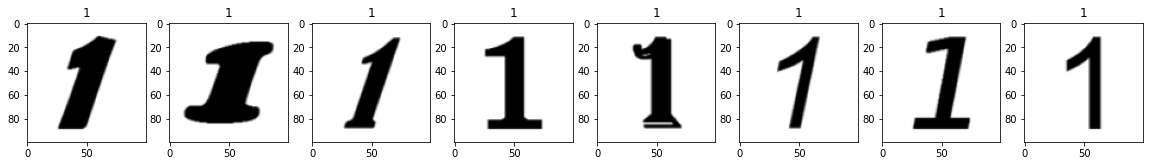

In [ ]:

# visualize data
# character - encoded_label dict , 데이터 확인해보고 싶을 때 참조
label_dict = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 
'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17,
'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'P': 24, 'Q': 25, 
'R': 26, 'S': 27, 'T': 28, 'U': 29, 'V': 30, 'W': 31, 'X': 32, 'Y': 33, 
'Z': 34, 'a': 35, 'b': 36, 'd': 37, 'e': 38, 'f': 39, 'g': 40, 'h': 41, 
'i': 42, 'j': 43, 'm': 44, 'n': 45, 'o': 46, 'q': 47, 'r': 48, 't': 49, 'u': 50, 'y': 51}

# image_show function : num 수 만큼 dataset 내의 data를 보여주는 함수
def image_show(dataset, num):
  fig = plt.figure(figsize=(20,20))

  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.imshow(dataset[i+1200][0].squeeze(), cmap = "gray")
    plt.title(dataset[i+1200][1])

image_show(train_data, 8)

In [ ]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Sun Dec 18 14:29:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    28W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
in_chabnnel=1
kernel_sizes=5
paddings=2
strides=1
max_pool_kernel=2
learning_rate=0.001
num_epochs=20
num_classes=52

In [ ]:
kernel_sizes=5
paddings=2
strides=1
max_pool_kernel=2
learning_rate=0.001
batch_size = 50

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=in_chabnnel, out_channels=16, kernel_size=kernel_sizes, stride=1, padding=2),
        nn.BatchNorm2d(num_features=16),  
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=max_pool_kernel)
    )
    
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=kernel_sizes, stride=1, padding=2),
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=max_pool_kernel)
    )
    
    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_sizes, stride=1, padding=2),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=max_pool_kernel)
    )
    self.layer4 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_sizes, stride=strides, padding=paddings),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=max_pool_kernel)
    )
    self.layer5 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=kernel_sizes, stride=strides, padding=paddings),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=max_pool_kernel)
    )
    
    self.fc1 = nn.Linear(in_features=256*3*3, out_features=416)
    self.fc2 = nn.Linear(in_features=416, out_features=52)
    self.fc3 = nn.Linear(in_features=128, out_features=52)
    self.dropout1 = nn.Dropout(0.15)
    self.dropout2 = nn.Dropout(0.4)
 
  def forward(self, x):    
    x = self.layer1(x)
    x = self.dropout1(x)    
    x = self.layer2(x)  
    x = self.dropout1(x)  
    x = self.layer3(x)
    x = self.dropout1(x)
    x = self.layer4(x)
    x = self.dropout1(x)
    x = self.layer5(x)
    x = self.dropout1(x)

    x = F.relu(x)
    x=torch.flatten(x,1)  
    x = F.relu(self.fc1(x))
    x = self.dropout2(x)     
    x=self.fc2(x)
    #x = F.relu(self.fc2(x))
    #x = self.dropout2(x)
    #x = self.fc3(x)
    return x

model = CNN().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0005)

In [ ]:
start = time.time() # Train 시작 시간 정보 저장
######## Train ########
last_acc=0
patience=2
ES=0
ESS=0
tr_loss = []
tr_acc = []
v_loss = []
v_acc = []

best_valid_loss = torch.inf
best_epoch = 0
model = model.to(device)
epochloop = tqdm(range(num_epochs), position=0, desc='Training', leave=True)
for epoch in epochloop:
  model.train()
  train_loss = 0
  train_acc = 0


  ## Train
  for i, (img,label) in enumerate(train_loader, 0):
    epochloop.set_postfix_str(f'Training batch {i}/{len(train_loader)}') # visualize
        
    img = img.to(device)
    label = label.to(device)

    outputs = model(img).to(device)
    
    optimizer.zero_grad()
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()

    # acc
    _, outputs = torch.max(outputs.data, 1)
    train_acc += (outputs==label).sum()
    # loss
    train_loss += loss.item()

  ## Validation
  model.eval()
  val_loss = 0
  val_acc = 0

  with torch.no_grad():
      for i, (img, label) in enumerate(valid_loader):
          epochloop.set_postfix_str(f'Validation batch {i}/{len(valid_loader)}')
          img = img.to(device)
          label = label.to(device)

          outputs = model(img).to(device)
          # acc
          _, outputs = torch.max(outputs.data, 1)
          val_acc += (outputs==label).sum()
          # loss
          val_loss += loss.item()



  
  model.train()
  # save model if validation loss decrease
  if val_loss / len(valid_data) <= best_valid_loss:
      best_valid_loss = val_loss / len(valid_loader)
      best_epoch = epoch
      torch.save(model.state_dict(), "model_epoch_{}.pth".format(epoch))         # layer, kernel, padding, drop1, drop2

      print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_data) * 100}% |  Val Acc: {val_acc / len(valid_data) * 100}%')


  print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss / len(train_loader):.3f} Train Acc: {train_acc / len(train_data) * 100}% |  Val Acc: {val_acc / len(valid_data) * 100}%')
  

  current_acc=val_acc / len(valid_data)
  if current_acc < last_acc:
    torch.save(model.state_dict(), "earlystop1.pth")
    ES+=1
  if ES==2:
    print(epoch)
    print('earlystop')
    #break
  last_acc=current_acc


  tr_loss.append(train_loss / len(train_loader))
  tr_acc.append(train_acc.cpu().numpy() / len(train_data) * 100)
  v_loss.append(val_loss / len(valid_loader))
  v_acc.append(val_acc.cpu().numpy() / len(valid_data) * 100)

end = time.time() # Train 종료 시간 정보 저장
duration = end - start # 종료 시간 - 시작 시간
print("Training takes {:.2f}minutes".format(duration/60)) #초 단위로 저장되므로, 60으로 나누어 분으로 표시

Training:   5%|▌         | 1/20 [00:29<09:26, 29.79s/it, Training batch 3/745]

Epoch 1/20 | Train Loss: 0.362 Train Acc: 90.29597473144531% |  Val Acc: 90.6153793334961%
Epoch 1/20 | Train Loss: 0.362 Train Acc: 90.29597473144531% |  Val Acc: 90.6153793334961%


Training:  10%|█         | 2/20 [01:00<09:01, 30.08s/it, Training batch 4/745]

Epoch 2/20 | Train Loss: 0.318 Train Acc: 91.12590789794922% |  Val Acc: 87.24358367919922%
Epoch 2/20 | Train Loss: 0.318 Train Acc: 91.12590789794922% |  Val Acc: 87.24358367919922%


Training:  15%|█▌        | 3/20 [01:30<08:31, 30.07s/it, Training batch 4/745]

Epoch 3/20 | Train Loss: 0.287 Train Acc: 92.14385223388672% |  Val Acc: 94.58973693847656%
Epoch 3/20 | Train Loss: 0.287 Train Acc: 92.14385223388672% |  Val Acc: 94.58973693847656%


Training:  20%|██        | 4/20 [01:59<07:57, 29.87s/it, Training batch 4/745]

Epoch 4/20 | Train Loss: 0.262 Train Acc: 92.65416717529297% |  Val Acc: 95.1153793334961%
Epoch 4/20 | Train Loss: 0.262 Train Acc: 92.65416717529297% |  Val Acc: 95.1153793334961%


Training:  25%|██▌       | 5/20 [02:29<07:26, 29.75s/it, Training batch 3/745]

Epoch 5/20 | Train Loss: 0.242 Train Acc: 93.23699188232422% |  Val Acc: 94.76922607421875%
Epoch 5/20 | Train Loss: 0.242 Train Acc: 93.23699188232422% |  Val Acc: 94.76922607421875%
4
earlystop


Training:  30%|███       | 6/20 [02:58<06:55, 29.67s/it, Training batch 4/745]

Epoch 6/20 | Train Loss: 0.235 Train Acc: 93.33100128173828% |  Val Acc: 95.14102172851562%
Epoch 6/20 | Train Loss: 0.235 Train Acc: 93.33100128173828% |  Val Acc: 95.14102172851562%
5
earlystop


Training:  35%|███▌      | 7/20 [03:28<06:25, 29.63s/it, Training batch 4/745]

Epoch 7/20 | Train Loss: 0.217 Train Acc: 93.77685546875% |  Val Acc: 95.19229888916016%
Epoch 7/20 | Train Loss: 0.217 Train Acc: 93.77685546875% |  Val Acc: 95.19229888916016%
6
earlystop


Training:  40%|████      | 8/20 [03:58<05:55, 29.65s/it, Training batch 3/745]

Epoch 8/20 | Train Loss: 0.214 Train Acc: 93.87622833251953% |  Val Acc: 94.79486846923828%
Epoch 8/20 | Train Loss: 0.214 Train Acc: 93.87622833251953% |  Val Acc: 94.79486846923828%


Training:  45%|████▌     | 9/20 [04:27<05:26, 29.64s/it, Training batch 3/745]

Epoch 9/20 | Train Loss: 0.203 Train Acc: 94.16361999511719% |  Val Acc: 88.33333587646484%
Epoch 9/20 | Train Loss: 0.203 Train Acc: 94.16361999511719% |  Val Acc: 88.33333587646484%


Training:  50%|█████     | 10/20 [04:57<04:56, 29.67s/it, Training batch 4/745]

Epoch 10/20 | Train Loss: 0.196 Train Acc: 94.39460754394531% |  Val Acc: 95.97435760498047%
Epoch 10/20 | Train Loss: 0.196 Train Acc: 94.39460754394531% |  Val Acc: 95.97435760498047%


Training:  55%|█████▌    | 11/20 [05:26<04:26, 29.61s/it, Training batch 4/745]

Epoch 11/20 | Train Loss: 0.187 Train Acc: 94.6175308227539% |  Val Acc: 81.85897064208984%
Epoch 11/20 | Train Loss: 0.187 Train Acc: 94.6175308227539% |  Val Acc: 81.85897064208984%


Training:  60%|██████    | 12/20 [05:56<03:56, 29.61s/it, Training batch 4/745]

Epoch 12/20 | Train Loss: 0.183 Train Acc: 94.65782165527344% |  Val Acc: 95.94871520996094%
Epoch 12/20 | Train Loss: 0.183 Train Acc: 94.65782165527344% |  Val Acc: 95.94871520996094%


Training:  65%|██████▌   | 13/20 [06:26<03:27, 29.62s/it, Training batch 4/745]

Epoch 13/20 | Train Loss: 0.175 Train Acc: 94.9828109741211% |  Val Acc: 96.08973693847656%
Epoch 13/20 | Train Loss: 0.175 Train Acc: 94.9828109741211% |  Val Acc: 96.08973693847656%


Training:  70%|███████   | 14/20 [06:56<02:58, 29.69s/it, Training batch 3/745]

Epoch 14/20 | Train Loss: 0.170 Train Acc: 95.05801391601562% |  Val Acc: 95.85897064208984%
Epoch 14/20 | Train Loss: 0.170 Train Acc: 95.05801391601562% |  Val Acc: 95.85897064208984%


Training:  75%|███████▌  | 15/20 [07:25<02:28, 29.67s/it, Training batch 4/745]

Epoch 15/20 | Train Loss: 0.166 Train Acc: 95.12516021728516% |  Val Acc: 95.52564239501953%
Epoch 15/20 | Train Loss: 0.166 Train Acc: 95.12516021728516% |  Val Acc: 95.52564239501953%


Training:  80%|████████  | 16/20 [07:55<01:58, 29.66s/it, Training batch 4/745]

Epoch 16/20 | Train Loss: 0.164 Train Acc: 95.21110534667969% |  Val Acc: 94.76922607421875%
Epoch 16/20 | Train Loss: 0.164 Train Acc: 95.21110534667969% |  Val Acc: 94.76922607421875%


Training:  85%|████████▌ | 17/20 [08:24<01:28, 29.65s/it, Training batch 4/745]

Epoch 17/20 | Train Loss: 0.160 Train Acc: 95.34002685546875% |  Val Acc: 96.19230651855469%
Epoch 17/20 | Train Loss: 0.160 Train Acc: 95.34002685546875% |  Val Acc: 96.19230651855469%


Training:  90%|█████████ | 18/20 [08:54<00:59, 29.62s/it, Training batch 3/745]

Epoch 18/20 | Train Loss: 0.156 Train Acc: 95.39643096923828% |  Val Acc: 96.07691955566406%
Epoch 18/20 | Train Loss: 0.156 Train Acc: 95.39643096923828% |  Val Acc: 96.07691955566406%


Training:  95%|█████████▌| 19/20 [09:24<00:29, 29.59s/it, Training batch 4/745]

Epoch 19/20 | Train Loss: 0.149 Train Acc: 95.61398315429688% |  Val Acc: 94.53845977783203%
Epoch 19/20 | Train Loss: 0.149 Train Acc: 95.61398315429688% |  Val Acc: 94.53845977783203%


Training: 100%|██████████| 20/20 [09:53<00:00, 29.67s/it, Validation batch 155/156]

Epoch 20/20 | Train Loss: 0.151 Train Acc: 95.56295013427734% |  Val Acc: 96.16666412353516%
Epoch 20/20 | Train Loss: 0.151 Train Acc: 95.56295013427734% |  Val Acc: 96.16666412353516%
Training takes 9.89minutes


In [ ]:
torch.save(model.state_dict(),"my_model.pth")   # model의 weight 정보 만을 저장

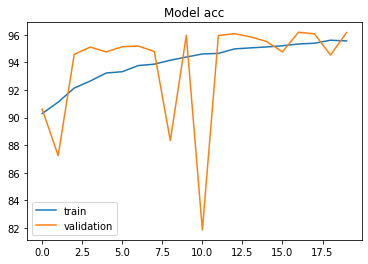

In [ ]:
plt.plot(tr_acc, label='train')

plt.plot(v_acc, label='validation')


plt.legend()
plt.title("Model acc")
plt.show()

In [ ]:
valid_model = CNN().to(device)

valid_model.load_state_dict(torch.load("my_model.pth"))   # test_model이라는 모델 안에 앞서 학습한 weight 정보가 담기게 된다.

valid_model.eval()

with torch.no_grad():
  correct = 0
  
  for img, lab in valid_loader:
    img = img.to(device)
    lab = lab.to(device)
    out = valid_model(img)
    _, pred = torch.max(out.data, 1)
    correct += (pred == lab).sum().item()

  print("Accuracy of the network on the {} test images: {}%".format(len(valid_loader)*batch_size, 100 * correct / (len(valid_loader) * batch_size)))

Accuracy of the network on the 7800 test images: 96.16666666666667%


In [ ]:

import time
start = time.time() # Train 시작 시간 정보 저장
##원하는 동작 수행##
end = time.time() # Train 종료 시간 정보 저장
duration = end - start # 종료 시간 - 시작 시간
print("Training takes {:.2f}minutes".format(duration/60)) #초 단위로 저장되므로, 60으로 나누어 분으로 표시
     

Training takes 0.00minutes


In [ ]:

import time


def elapsed(f):
    def wrap(*args):
        start_r = time.perf_counter()
        start_p = time.process_time()
        # 함수 실행
        ret = f(*args)
        
        end_r = time.perf_counter()
        end_p = time.process_time()
        elapsed_r = end_r - start_r
        elapsed_p = end_p - start_p

        print(f'{f.__name__} elapsed: {elapsed_r:.6f}sec (real) / {elapsed_p:.6f}sec (cpu)')
        return ret
   # 함수 객체를 return
    return wrap



@elapsed
def comp_flat(l):
    return [item for sublist in m for item in sublist]

@elapsed
def sum_flat(l):
    return sum(l,[])

    
if __name__ == "__main__":
    m = [
        [1,2,3],
        [4,5,6],
        [7,8,9]]
    
    sum_flat(m)
    comp_flat(m)

sum_flat elapsed: 0.000010sec (real) / 0.000007sec (cpu)
comp_flat elapsed: 0.000008sec (real) / 0.000007sec (cpu)
